<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/CNN_Multiclass_File_Dataset_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=a1dc395f82593dc4614afb9a4f39efb99f77430641442aa3c4d55057281f53b0
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block
from jcopdl.utils.dataloader import MultilabelDataset

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
bs = 64
crop_size = 32

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
    ])

# Download and load the training data
trainset = datasets.CIFAR10('/content/cifar2/', download=True, train=True, transform=train_transform)
trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)

testset = datasets.CIFAR10('/content/cifar2/', download=True, train=False, transform=test_transform)
testloader = DataLoader(testset, batch_size=bs, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
label2cat = trainset.classes
feature, targer = next(iter(trainloader))
label2cat

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class CNN(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.conv = nn.Sequential(
          conv_block(3, 8),
          conv_block(8, 16),
          conv_block(16, 32),
        
          nn.Flatten()
      )
    self.fc = nn.Sequential(
      linear_block(32*4*4, 256, dropout=0.1), #1024 dapet dari 64x4x4
      linear_block(256, output_size, activation='lsoftmax')
      )
  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [ ]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(trainset.classes)
})

In [ ]:
model = CNN(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=5, outdir='model')

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 1.7415 | Test_cost  = 1.4728 | Train_score = 0.3585 | Test_score = 0.4633 |




Epoch     2
Train_cost  = 1.4666 | Test_cost  = 1.3348 | Train_score = 0.4702 | Test_score = 0.5145 |




Epoch     3
Train_cost  = 1.3638 | Test_cost  = 1.2304 | Train_score = 0.5082 | Test_score = 0.5564 |




Epoch     4
Train_cost  = 1.2861 | Test_cost  = 1.1898 | Train_score = 0.5381 | Test_score = 0.5756 |




Epoch     5
Train_cost  = 1.2280 | Test_cost  = 1.1157 | Train_score = 0.5607 | Test_score = 0.6040 |




Epoch     6
Train_cost  = 1.1782 | Test_cost  = 1.1049 | Train_score = 0.5794 | Test_score = 0.6072 |




Epoch     7
Train_cost  = 1.1402 | Test_cost  = 1.0472 | Train_score = 0.5942 | Test_score = 0.6272 |




Epoch     8
Train_cost  = 1.1118 | Test_cost  = 1.0578 | Train_score = 0.6062 | Test_score = 0.6252 |
==> EarlyStop patience =  1 | Best test_score: 0.6272




Epoch     9
Train_cost  = 1.0843 | Test_cost  = 0.9910 | Train_score = 0.6140 | Test_score = 0.6470 |




Epoch    10
Train_cost  = 1.0652 | Test_cost  = 1.0408 | Train_score = 0.6213 | Test_score = 0.6359 |
==> EarlyStop patience =  1 | Best test_score: 0.6470




Epoch    11
Train_cost  = 1.0477 | Test_cost  = 1.0034 | Train_score = 0.6290 | Test_score = 0.6451 |
==> EarlyStop patience =  2 | Best test_score: 0.6470




Epoch    12
Train_cost  = 1.0305 | Test_cost  = 0.9789 | Train_score = 0.6324 | Test_score = 0.6590 |




Epoch    13
Train_cost  = 1.0156 | Test_cost  = 0.9599 | Train_score = 0.6395 | Test_score = 0.6623 |




Epoch    14
Train_cost  = 1.0009 | Test_cost  = 0.9803 | Train_score = 0.6470 | Test_score = 0.6570 |
==> EarlyStop patience =  1 | Best test_score: 0.6623




Epoch    15
Train_cost  = 0.9842 | Test_cost  = 0.8987 | Train_score = 0.6512 | Test_score = 0.6830 |




Epoch    16
Train_cost  = 0.9776 | Test_cost  = 0.9789 | Train_score = 0.6534 | Test_score = 0.6655 |
==> EarlyStop patience =  1 | Best test_score: 0.6830




Epoch    17
Train_cost  = 0.9644 | Test_cost  = 0.9619 | Train_score = 0.6595 | Test_score = 0.6716 |
==> EarlyStop patience =  2 | Best test_score: 0.6830




Epoch    18
Train_cost  = 0.9578 | Test_cost  = 0.8862 | Train_score = 0.6619 | Test_score = 0.6907 |




Epoch    19
Train_cost  = 0.9446 | Test_cost  = 0.9308 | Train_score = 0.6672 | Test_score = 0.6763 |
==> EarlyStop patience =  1 | Best test_score: 0.6907




Epoch    20
Train_cost  = 0.9366 | Test_cost  = 0.8930 | Train_score = 0.6708 | Test_score = 0.6925 |


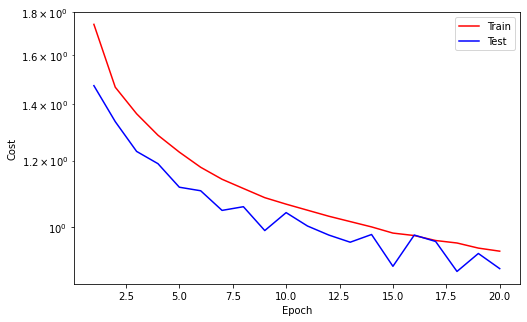

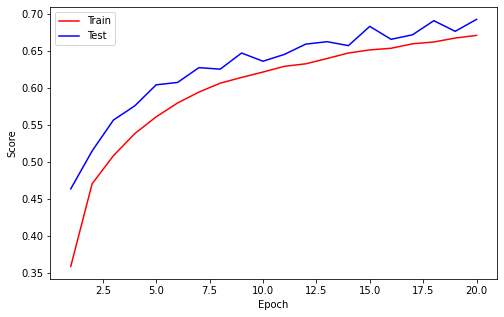



Epoch    21
Train_cost  = 0.9300 | Test_cost  = 0.8818 | Train_score = 0.6695 | Test_score = 0.6891 |
==> EarlyStop patience =  1 | Best test_score: 0.6925




Epoch    22
Train_cost  = 0.9241 | Test_cost  = 0.8690 | Train_score = 0.6728 | Test_score = 0.6972 |




Epoch    23
Train_cost  = 0.9105 | Test_cost  = 0.8505 | Train_score = 0.6807 | Test_score = 0.7044 |




Epoch    24
Train_cost  = 0.8972 | Test_cost  = 0.9573 | Train_score = 0.6815 | Test_score = 0.6735 |
==> EarlyStop patience =  1 | Best test_score: 0.7044




Epoch    25
Train_cost  = 0.8998 | Test_cost  = 0.8624 | Train_score = 0.6810 | Test_score = 0.7037 |
==> EarlyStop patience =  2 | Best test_score: 0.7044




Epoch    26
Train_cost  = 0.8920 | Test_cost  = 0.8810 | Train_score = 0.6843 | Test_score = 0.6901 |
==> EarlyStop patience =  3 | Best test_score: 0.7044




Epoch    27
Train_cost  = 0.8872 | Test_cost  = 0.8602 | Train_score = 0.6869 | Test_score = 0.7072 |




Epoch    28
Train_cost  = 0.8765 | Test_cost  = 0.8340 | Train_score = 0.6905 | Test_score = 0.7111 |




Epoch    29
Train_cost  = 0.8731 | Test_cost  = 0.8762 | Train_score = 0.6921 | Test_score = 0.6928 |
==> EarlyStop patience =  1 | Best test_score: 0.7111




Epoch    30
Train_cost  = 0.8654 | Test_cost  = 0.8709 | Train_score = 0.6956 | Test_score = 0.7052 |
==> EarlyStop patience =  2 | Best test_score: 0.7111




Epoch    31
Train_cost  = 0.8634 | Test_cost  = 0.8412 | Train_score = 0.6958 | Test_score = 0.7090 |
==> EarlyStop patience =  3 | Best test_score: 0.7111




Epoch    32
Train_cost  = 0.8595 | Test_cost  = 0.8243 | Train_score = 0.6954 | Test_score = 0.7126 |




Epoch    33
Train_cost  = 0.8589 | Test_cost  = 0.8885 | Train_score = 0.6966 | Test_score = 0.6997 |
==> EarlyStop patience =  1 | Best test_score: 0.7126




Epoch    34
Train_cost  = 0.8505 | Test_cost  = 0.8071 | Train_score = 0.7007 | Test_score = 0.7165 |




Epoch    35
Train_cost  = 0.8518 | Test_cost  = 0.8355 | Train_score = 0.6982 | Test_score = 0.7106 |
==> EarlyStop patience =  1 | Best test_score: 0.7165




Epoch    36
Train_cost  = 0.8460 | Test_cost  = 0.8155 | Train_score = 0.6997 | Test_score = 0.7162 |
==> EarlyStop patience =  2 | Best test_score: 0.7165




Epoch    37
Train_cost  = 0.8455 | Test_cost  = 0.8020 | Train_score = 0.7010 | Test_score = 0.7229 |




Epoch    38
Train_cost  = 0.8402 | Test_cost  = 0.8410 | Train_score = 0.7041 | Test_score = 0.7134 |
==> EarlyStop patience =  1 | Best test_score: 0.7229




Epoch    39
Train_cost  = 0.8326 | Test_cost  = 0.8042 | Train_score = 0.7048 | Test_score = 0.7229 |
==> EarlyStop patience =  2 | Best test_score: 0.7229




Epoch    40
Train_cost  = 0.8295 | Test_cost  = 0.8168 | Train_score = 0.7055 | Test_score = 0.7201 |


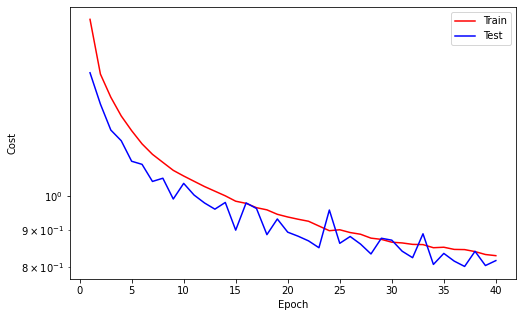

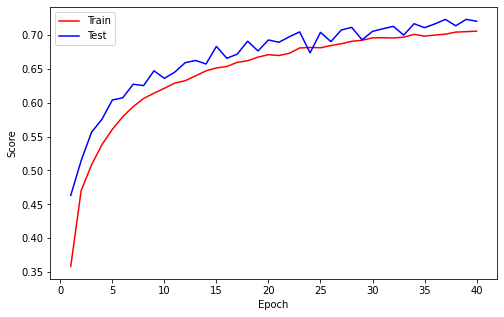

==> EarlyStop patience =  3 | Best test_score: 0.7229




Epoch    41
Train_cost  = 0.8315 | Test_cost  = 0.8041 | Train_score = 0.7049 | Test_score = 0.7239 |




Epoch    42
Train_cost  = 0.8283 | Test_cost  = 0.8146 | Train_score = 0.7055 | Test_score = 0.7221 |
==> EarlyStop patience =  1 | Best test_score: 0.7239




Epoch    43
Train_cost  = 0.8200 | Test_cost  = 0.8892 | Train_score = 0.7116 | Test_score = 0.7033 |
==> EarlyStop patience =  2 | Best test_score: 0.7239




Epoch    44
Train_cost  = 0.8180 | Test_cost  = 0.8301 | Train_score = 0.7100 | Test_score = 0.7195 |
==> EarlyStop patience =  3 | Best test_score: 0.7239




Epoch    45
Train_cost  = 0.8152 | Test_cost  = 0.7798 | Train_score = 0.7123 | Test_score = 0.7331 |




Epoch    46
Train_cost  = 0.8197 | Test_cost  = 0.8433 | Train_score = 0.7113 | Test_score = 0.7106 |
==> EarlyStop patience =  1 | Best test_score: 0.7331




Epoch    47
Train_cost  = 0.8123 | Test_cost  = 0.8135 | Train_score = 0.7142 | Test_score = 0.7191 |
==> EarlyStop patience =  2 | Best test_score: 0.7331




Epoch    48
Train_cost  = 0.8116 | Test_cost  = 0.7865 | Train_score = 0.7124 | Test_score = 0.7314 |
==> EarlyStop patience =  3 | Best test_score: 0.7331




Epoch    49
Train_cost  = 0.8026 | Test_cost  = 0.8255 | Train_score = 0.7173 | Test_score = 0.7198 |
==> EarlyStop patience =  4 | Best test_score: 0.7331




Epoch    50
Train_cost  = 0.8037 | Test_cost  = 0.8225 | Train_score = 0.7138 | Test_score = 0.7228 |
==> EarlyStop patience =  5 | Best test_score: 0.7331
==> Execute Early Stopping at epoch: 50 | Best test_score: 0.7331
==> Best model is saved at model


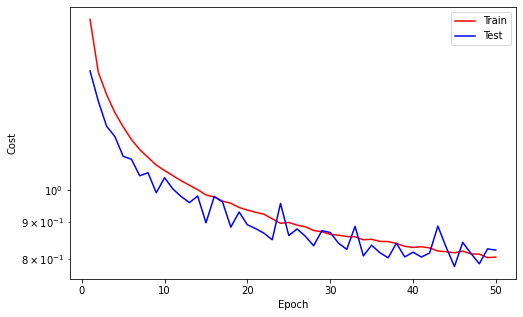

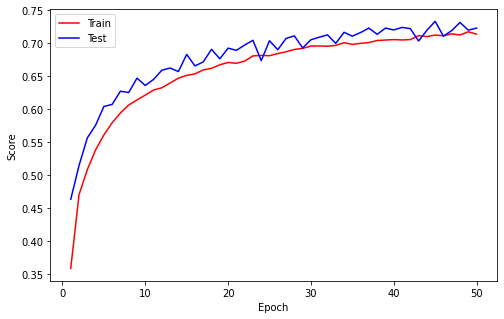

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', testset, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([1, 7, 2, 4, 7, 5, 2, 5, 1, 5, 8, 9, 4, 9, 5, 3, 0, 4, 0, 1, 4, 7, 5, 6,
        1, 9, 5, 0, 7, 4, 9, 6, 8, 4, 2, 8, 4, 2, 6, 1, 5, 6, 2, 8, 6, 1, 6, 3,
        0, 0, 1, 4, 3, 0, 3, 9, 2, 8, 7, 4, 2, 9, 0, 8], device='cuda:0')

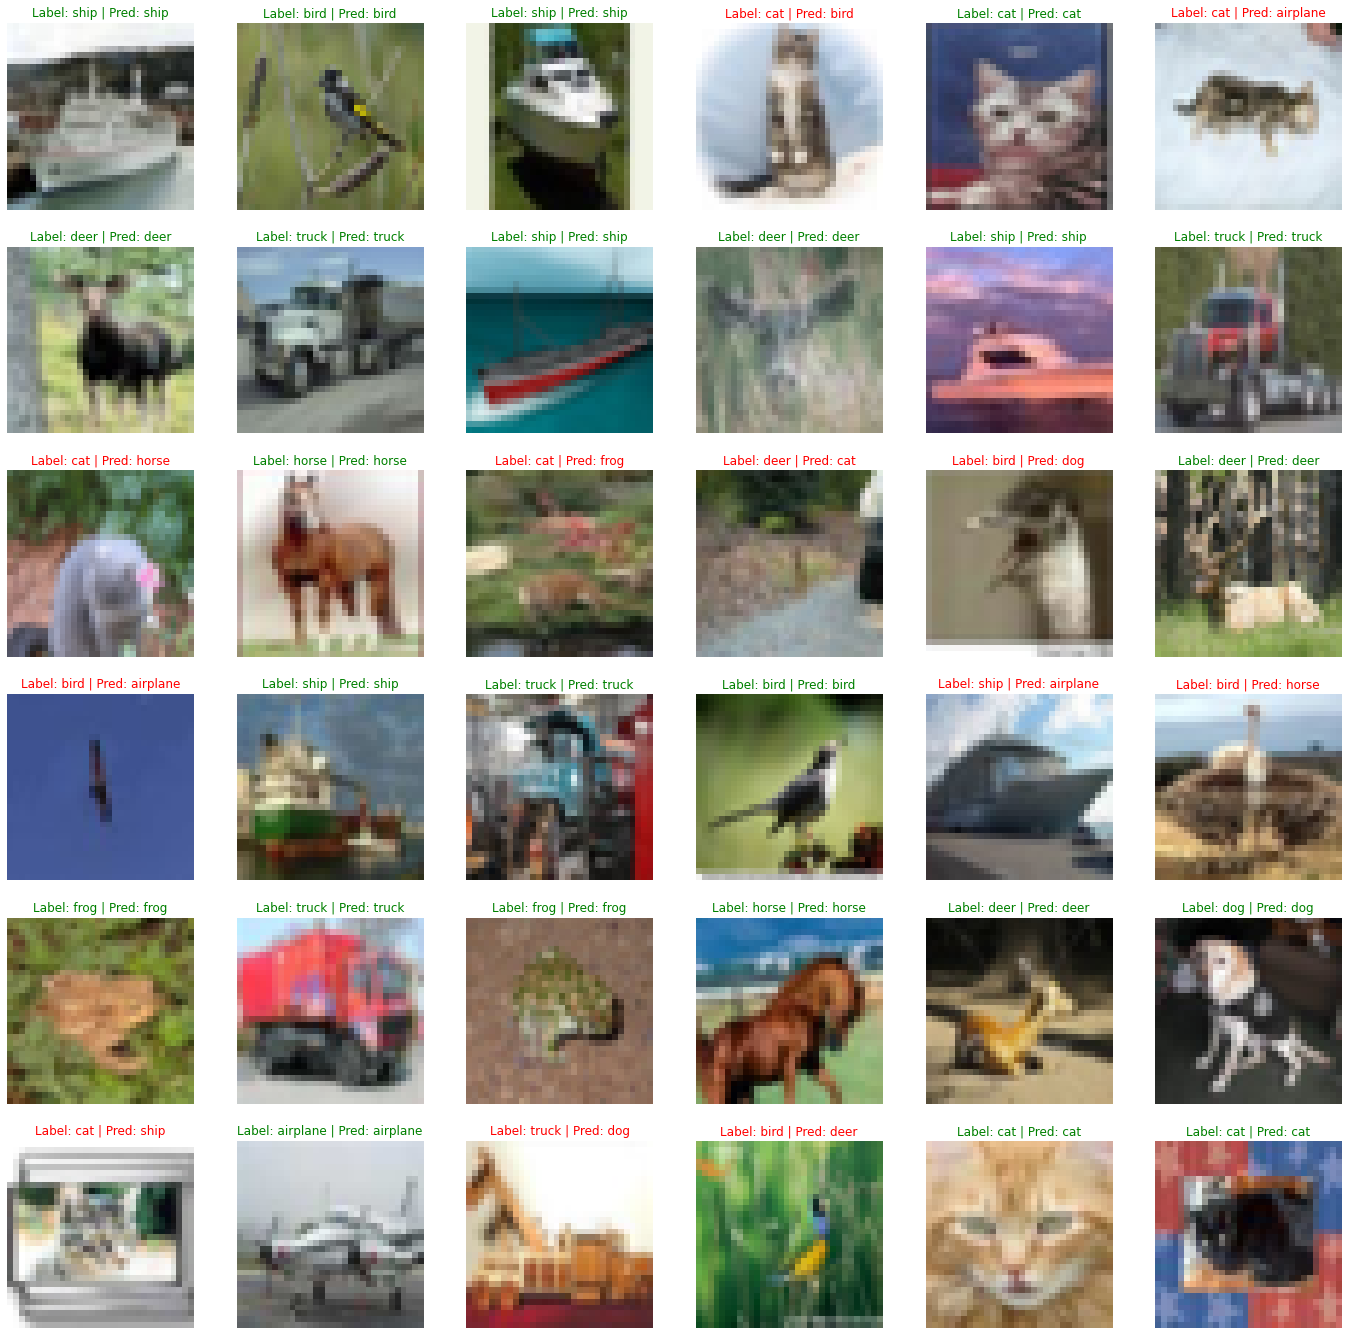

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
  ax.axis("off");

In [ ]:
from PIL import Image

In [ ]:
loader = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
    ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.cuda()

image = image_loader("/content/Dian sastro 4.jpg")
with torch.no_grad():
  model.eval()
  output = model(image)
  preds = output.argmax(1)
  print(label2cat[preds])

  """
  print(prediksi)
  for x in prediksi:
    start = 0
    for i in x:
      if i == 1:
        print(f"Prediksi: {label2cat[start]}")
      start+=1
  """

deer
